# Fine tuning Florence-2

En el post [Florence-2](https://maximofn.com/florence-2/) ya explicamos el modelo Florence-2 y vimos cómo usarlo. Así que en este post vamos a ver cómo hacerle fine tuning.

## Fine tuning para Document VQA

Este fine tuning está basado en el post de [Merve Noyan](https://huggingface.co/merve), [Andres Marafioti](https://huggingface.co/andito) y [Piotr Skalski](https://huggingface.co/SkalskiP), [Fine-tuning Florence-2 - Microsoft's Cutting-edge Vision Language Models](https://huggingface.co/blog/finetune-florence2), en el que explican que aunque este método es muy completo no permite hacer preguntas sobre documentos, así que hacen un reentreno con el dataset [DocumentVQA](https://huggingface.co/datasets/HuggingFaceM4/DocumentVQA)

Lo que yo aporto es a parte de hacer este fine tuning hacerlo con la librería `accelerate` para poder hacerlo en paralelo en varias GPUs de manera sencilla. En mi caso haré el fine tuning con 2 GPUs RTX 3090.

### Dataset

En primer lugar descargamos el dataset

In [1]:
from datasets import load_dataset

data = load_dataset("HuggingFaceM4/DocumentVQA")

data

Resolving data files:   0%|          | 0/38 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/38 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/51 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['questionId', 'question', 'question_types', 'image', 'docId', 'ucsf_document_id', 'ucsf_document_page_no', 'answers'],
        num_rows: 39463
    })
    validation: Dataset({
        features: ['questionId', 'question', 'question_types', 'image', 'docId', 'ucsf_document_id', 'ucsf_document_page_no', 'answers'],
        num_rows: 5349
    })
    test: Dataset({
        features: ['questionId', 'question', 'question_types', 'image', 'docId', 'ucsf_document_id', 'ucsf_document_page_no', 'answers'],
        num_rows: 5188
    })
})

Instanciamos también el modelo

In [2]:
from transformers import AutoModelForCausalLM, AutoProcessor
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoints = 'microsoft/Florence-2-base-ft'
revision = 'refs/pr/6'
model = AutoModelForCausalLM.from_pretrained(checkpoints, trust_remote_code=True, revision=revision).to(device)
processor = AutoProcessor.from_pretrained(checkpoints, trust_remote_code=True, revision=revision)

Al igual que en post [Florence-2](https://maximofn.com/florence-2/) creamos una función para pedirle respuestas al modelo

In [3]:
def create_prompt(task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    return prompt

In [4]:
def generate_answer(task_prompt, text_input=None, image=None):
    # Create prompt
    prompt = create_prompt(task_prompt, text_input)

    # Ensure the image is in RGB mode
    if image.mode != "RGB":
        image = image.convert("RGB")

    # Get inputs
    inputs = processor(text=prompt, images=image, return_tensors="pt").to('cuda')

    # Get outputs
    generated_ids = model.generate(
      input_ids=inputs["input_ids"],
      pixel_values=inputs["pixel_values"],
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )

    # Decode the generated IDs
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]

    # Post-process the generated text
    parsed_answer = processor.post_process_generation(
        generated_text, 
        task=task_prompt, 
        image_size=(image.width, image.height)
    )

    return parsed_answer

Probamos el modelo con 3 documentos del dataset, con la tarea `DocVQA` a ver si obtenemos algo

{'DocVQA': 'unanswerable'}


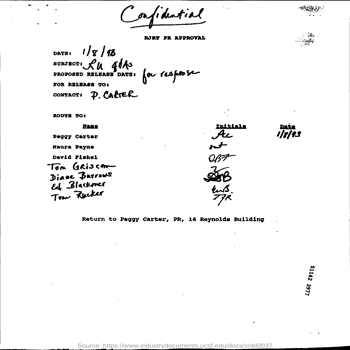

{'DocVQA': 'unanswerable'}


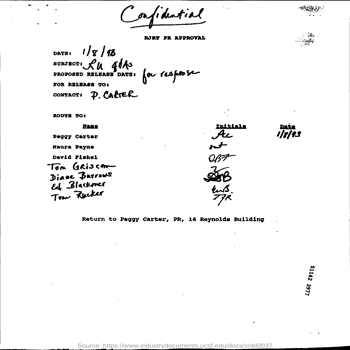

{'DocVQA': '499150498'}


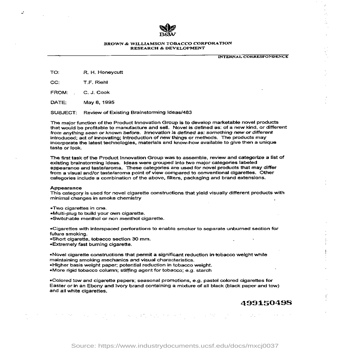

In [5]:
for idx in range(3):
  print(generate_answer(task_prompt="DocVQA", text_input='What do you see in this image?', image=data['train'][idx]['image']))
  display(data['train'][idx]['image'].resize([350, 350]))

Vemos que las respuestas no son buenas

Probamos ahora con la tarea `OCR`

{'<OCR>': 'ConfidentialDATE:11/8/18RJT FR APPROVALBUBJECT: Rl gdasPROPOSED RELEASE DATE:for responseFOR RELEASE TO!CONTRACT: P. CARTERROUTE TO!NameIntiifnPeggy CarterAce11/fesMura PayneDavid Fishhel037Tom Gisis Com-Diane BarrowsEd BlackmerTow KuckerReturn to Peggy Carter, PR, 16 Raynolds BuildingLLS. 2015Source: https://www.industrydocuments.ucsf.edu/docs/xnbl0037'}


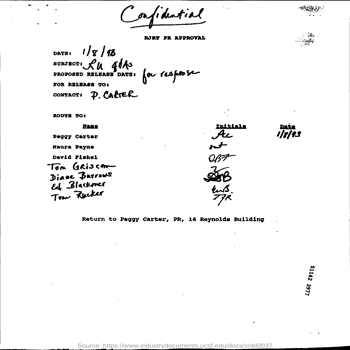

{'<OCR>': 'ConfidentialDATE:11/8/18RJT FR APPROVALBUBJECT: Rl gdasPROPOSED RELEASE DATE:for responseFOR RELEASE TO!CONTRACT: P. CARTERROUTE TO!NameIntiifnPeggy CarterAce11/fesMura PayneDavid Fishhel037Tom Gisis Com-Diane BarrowsEd BlackmerTow KuckerReturn to Peggy Carter, PR, 16 Raynolds BuildingLLS. 2015Source: https://www.industrydocuments.ucsf.edu/docs/xnbl0037'}


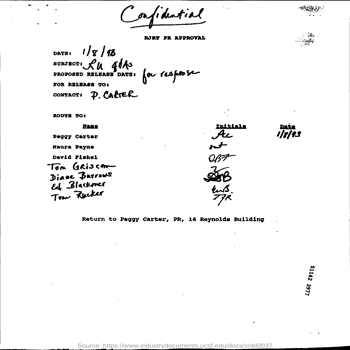

{'<OCR>': 'BSABROWN & WILLIAMSON JOBACCO CORPORATIONRESEARCH & DEVELOPMENTINTERNAL CORRESPONDENCETO:R. H. HoneycuttCC:C.J. CookFROM:May 9, 1995SUBJECT: Review of Existing Brainstorming Ideas/43The major function of the Product Innovation Ideas is developed marketable novel productsthat would be profile of the manufacturer and sell. Novel is defined as: a new kind, or differentfrom anything seen in known before, Innovation things as something is available. The products mayintroduced and the most technologies, materials and know, available to give a uniquetaste or tok.The first task of the product innovation was was an easy-view review and then a list ofexisting brainstorming ideas. These were group was used for two major categories that may differapparance and lerato,Ideas are grouped into two major products that may offercategories include a combination print of the above, flowers, and packaged and brand directions.ApparanceThis category is used in a novel cigarette constructions that 

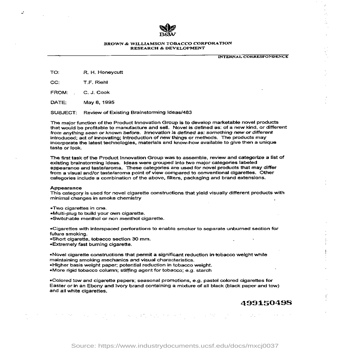

In [6]:
for idx in range(3):
  print(generate_answer(task_prompt="<OCR>", image=data['train'][idx]['image']))
  display(data['train'][idx]['image'].resize([350, 350]))

Obtenemos el texto de los documentos, pero no de qué tratan los documentos

Por último probamos con las tareas `CAPTION`

{'<CAPTION>': 'A certificate is stamped with the date of 18/18.'}
{'<DETAILED_CAPTION>': 'In this image we can see a paper with some text on it.'}
{'<MORE_DETAILED_CAPTION>': 'A letter is written in black ink on a white paper. The letters are written in a cursive language. The letter is addressed to peggy carter. '}


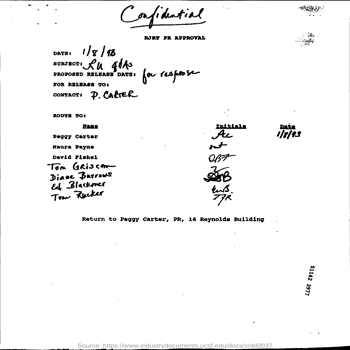

{'<CAPTION>': 'A certificate is stamped with the date of 18/18.'}
{'<DETAILED_CAPTION>': 'In this image we can see a paper with some text on it.'}
{'<MORE_DETAILED_CAPTION>': 'A letter is written in black ink on a white paper. The letters are written in a cursive language. The letter is addressed to peggy carter. '}


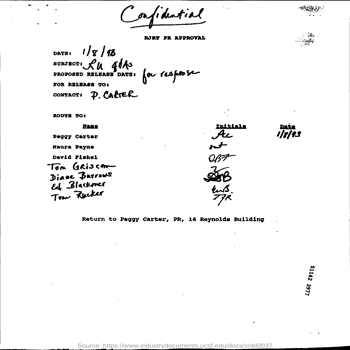

{'<CAPTION>': "a paper that says 'brown & williamson tobacco corporation research & development' on it"}
{'<DETAILED_CAPTION>': 'In this image we can see a paper with some text on it.'}
{'<MORE_DETAILED_CAPTION>': 'The image is a page from a book titled "Brown & Williamson Jobacco Corporation Research & Development".  The page is white and has black text.  The title of the page is "R. H. Honeycutt" at the top.  There is a logo of the company BSA in the top right corner.  A paragraph is written in black text below the title.'}


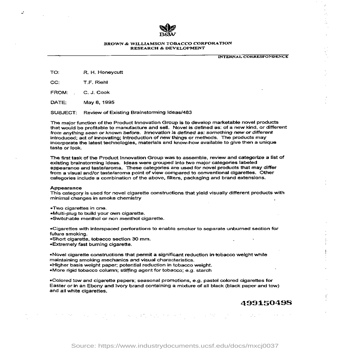

In [7]:
for idx in range(3):
  print(generate_answer(task_prompt="<CAPTION>", image=data['train'][idx]['image']))
  print(generate_answer(task_prompt="<DETAILED_CAPTION>", image=data['train'][idx]['image']))
  print(generate_answer(task_prompt="<MORE_DETAILED_CAPTION>", image=data['train'][idx]['image']))
  display(data['train'][idx]['image'].resize([350, 350]))

Tampoco nos valen estas respuestas, así que vamos a hacer el fine tuning

### Fine tuning

Primero creamos un dataset de Pytorch

In [9]:
from torch.utils.data import Dataset

class DocVQADataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        example = self.data[idx]
        question = "<DocVQA>" + example['question']
        first_answer = example['answers'][0]
        image = example['image']
        if image.mode != "RGB":
            image = image.convert("RGB")
        return question, first_answer, image

In [10]:
train_dataset = DocVQADataset(data['train'])
val_dataset = DocVQADataset(data['validation'])

Vamos a verlo

In [11]:
train_dataset[0]

('<DocVQA>what is the date mentioned in this letter?',
 '1/8/93',
 <PIL.Image.Image image mode=RGB size=1695x2025>)

In [12]:
data['train'][0]

{'questionId': 337,
 'question': 'what is the date mentioned in this letter?',
 'question_types': ['handwritten', 'form'],
 'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=1695x2025>,
 'docId': 279,
 'ucsf_document_id': 'xnbl0037',
 'ucsf_document_page_no': '1',
 'answers': ['1/8/93']}

Creamos un dataloader

In [13]:
import os
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import (AdamW, AutoProcessor, get_scheduler)

def collate_fn(batch):
    questions, answers, images = zip(*batch)
    inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True).to(device)
    return inputs, answers

# Create DataLoader
batch_size = 6
num_workers = 0

train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn, num_workers=num_workers, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn, num_workers=num_workers)

Vamos a ver una muestra

In [14]:
sample = next(iter(train_loader))

In [15]:
sample

({'input_ids': tensor([[    0, 41552, 42291,   846,  1864,   250, 15698,  2264,    16,     5,
           1248,  1982,    23,     5,   314,   299,  2797,     9,     5,  1842,
            116,     2,     1,     1,     1,     1,     1,     1],
         [    0, 41552, 42291,   846,  1864,   250, 15698,  2264,    16,     5,
             22, 47062,   113,    13,     5,    22, 46866,  5088,   113, 48615,
            306, 21948,   262,  3933, 15007,  4034, 24681,     2],
         [    0, 41552, 42291,   846,  1864,   250, 15698,  2264,    16,     5,
          15739,   849, 12270,   116,     2,     1,     1,     1,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1],
         [    0, 41552, 42291,   846,  1864,   250, 15698, 12375,    16,  2149,
             13,  5828,   849,   440,     4,   365,   116,     2,     1,     1,
              1,     1,     1,     1,     1,     1,     1,     1],
         [    0, 41552, 42291,   846,  1864,   250, 15698, 12196,    16,     5

La muestra en crudo es mucha información, así que vamos a ver la longitud de la muestra

In [16]:
len(sample)

2

Obtenemos una longitud de 2 porque tenemos la entrada al modelo y la respuesta

In [19]:
sample_inputs = sample[0]
sample_answers = sample[1]

Vemos la entrada

In [20]:
sample_inputs

{'input_ids': tensor([[    0, 41552, 42291,   846,  1864,   250, 15698,  2264,    16,     5,
          1248,  1982,    23,     5,   314,   299,  2797,     9,     5,  1842,
           116,     2,     1,     1,     1,     1,     1,     1],
        [    0, 41552, 42291,   846,  1864,   250, 15698,  2264,    16,     5,
            22, 47062,   113,    13,     5,    22, 46866,  5088,   113, 48615,
           306, 21948,   262,  3933, 15007,  4034, 24681,     2],
        [    0, 41552, 42291,   846,  1864,   250, 15698,  2264,    16,     5,
         15739,   849, 12270,   116,     2,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1],
        [    0, 41552, 42291,   846,  1864,   250, 15698, 12375,    16,  2149,
            13,  5828,   849,   440,     4,   365,   116,     2,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1],
        [    0, 41552, 42291,   846,  1864,   250, 15698, 12196,    16,     5,
          3

La entrada en crudo tambien tiene demasiada información, así que vamos a ver las keys

In [21]:
sample_inputs.keys()

dict_keys(['input_ids', 'attention_mask', 'pixel_values'])

Como vemos tenemos los `input_ids` y los `attention_mask` que corresponden al texto de entrada y los `pixel_values` que corresponden a la imagen. Vamos a ver la dimención de cada uno

In [22]:
sample_inputs['input_ids'].shape, sample_inputs['attention_mask'].shape, sample_inputs['pixel_values'].shape

(torch.Size([6, 28]), torch.Size([6, 28]), torch.Size([6, 3, 768, 768]))

En todos hay 6 elementos, porque al crear el dataloader pusimos un batch size de 6. En los `input_ids` y `attention_mask` cada elemento tiene 28 tokens y en los `pixel_values` cada elemento tiene 3 canales, 768 píxeles de alto y 768 píxeles de ancho

Vamos ahora a ver las respuestas

In [23]:
sample_answers

('oct-13-00', 'EC', '404', 'DW', 'BEYDXHJFK2', '011 44 113 387 6087')

Hemos obtenido 6 respuestas, por lo mismo que antes, porque al crear el dataloader pusimos un batch size de 6

In [24]:
len(sample_answers)

6

Creamos una función para hacer el fine tuning

In [26]:
def train_model(train_loader, val_loader, model, processor, epochs=10, lr=1e-6):
    optimizer = AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    best_val_loss = float('inf')
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        i = -1
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}"):
            i += 1
            inputs, answers = batch

            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(text=answers, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        print(f"Average Training Loss: {avg_train_loss}")

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}"):
                inputs, answers = batch

                input_ids = inputs["input_ids"]
                pixel_values = inputs["pixel_values"]
                labels = processor.tokenizer(text=answers, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids.to(device)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        print(f"Average Validation Loss: {avg_val_loss}")

        # Save best model checkpoint
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            output_dir = f"./model_checkpoints/epoch_{epoch+1}"
            os.makedirs(output_dir, exist_ok=True)
            model.save_pretrained(output_dir)
            processor.save_pretrained(output_dir)

Congelamos el codificador de visión para no tener problemas de VRAM

In [24]:
for param in model.vision_tower.parameters():
  param.is_trainable = False

Y ahora es cuando podríamos entrenar con 

```
train_model(train_loader, val_loader, model, processor, epochs=2)
```

Pero vamos a hacerlo con `accelerate` para poder hacerlo en paralelo en varias GPUs de manera sencilla

In [ ]:
# train_model(train_loader, val_loader, model, processor, epochs=2)

Reinicio el notebook para no tener problemas con la memoria

Creamos una función con todo el código anterior y añadiendo los cambios necesarios para usar `accelerate` que explicamos en el post de [accelerate](https://maximofn.com/hugging-face-accelerate/)

In [1]:
def train_model(BS=1, epochs=10, lr=1e-6, dataset_percentage=100):
    import torch
    from transformers import AutoModelForCausalLM, AutoProcessor, get_scheduler
    from accelerate import Accelerator
    from datasets import load_dataset
    from torch.utils.data import Dataset, DataLoader
    import os
    from tqdm import tqdm

    # Initialize Accelerator
    accelerator = Accelerator()
    
    # Load dataset
    accelerator.print(f"Loading dataset with {dataset_percentage}% of the data")
    data_train = load_dataset("HuggingFaceM4/DocumentVQA", split=f"train[:{dataset_percentage}%]")
    data_validation = load_dataset("HuggingFaceM4/DocumentVQA", split=f"validation[:{dataset_percentage}%]")
    data_test = load_dataset("HuggingFaceM4/DocumentVQA", split=f"test[:{dataset_percentage}%]")

    # Set device
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    device = accelerator.device

    # Load model and processor
    accelerator.print("Loading model and processor")
    checkpoints = 'microsoft/Florence-2-base-ft'
    revision = 'refs/pr/6'
    model = AutoModelForCausalLM.from_pretrained(checkpoints, trust_remote_code=True, revision=revision)#.to(device)
    processor = AutoProcessor.from_pretrained(checkpoints, trust_remote_code=True, revision=revision)

    # Freeze vision tower
    accelerator.print("Freezing vision tower")
    for param in model.vision_tower.parameters():
      param.is_trainable = False

    # Define Dataset class
    class DocVQADataset(Dataset):
        def __init__(self, data):
            self.data = data

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            example = self.data[idx]
            question = "<DocVQA>" + example['question']
            first_answer = example['answers'][0]
            image = example['image']
            if image.mode != "RGB":
                image = image.convert("RGB")
            return question, first_answer, image
    
    # Create datasets
    accelerator.print("Creating datasets")
    train_dataset = DocVQADataset(data_train)
    val_dataset = DocVQADataset(data_validation)

    # Define collate_fn for DataLoader
    def collate_fn(batch):
        questions, answers, images = zip(*batch)
        inputs = processor(text=list(questions), images=list(images), return_tensors="pt", padding=True)#.to(device)
        return inputs, answers

    # Create DataLoader
    accelerator.print("Creating DataLoaders")
    batch_size = BS
    num_workers = 0
    train_loader = DataLoader(train_dataset, batch_size=batch_size, collate_fn=collate_fn, num_workers=num_workers, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=collate_fn, num_workers=num_workers)
    
    # Create optimizer and scheduler
    accelerator.print("Creating optimizer and scheduler")
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    num_training_steps = epochs * len(train_loader)
    lr_scheduler = get_scheduler(
        name="linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps,
    )

    # Prepare model, optimizer, lr_scheduler, train_loader, val_loader
    accelerator.print("Preparing model, optimizer, lr_scheduler, train_loader, val_loader")
    model, optimizer, lr_scheduler, train_loader, val_loader = accelerator.prepare(model, optimizer, lr_scheduler, train_loader, val_loader)

    # Train model
    best_val_loss = float('inf')
    for epoch in range(epochs):

        # Training phase
        model.train()
        train_loss = 0
        i = -1
        for batch in tqdm(train_loader, desc=f"Training Epoch {epoch + 1}/{epochs}", disable=not accelerator.is_local_main_process):
            i += 1
            inputs, answers = batch

            input_ids = inputs["input_ids"]
            pixel_values = inputs["pixel_values"]
            labels = processor.tokenizer(text=answers, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids#.to(device)

            outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
            loss = outputs.loss

            # loss.backward()
            accelerator.backward(loss)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

            train_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        accelerator.print(f"Average Training Loss: {avg_train_loss}")

        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}/{epochs}", disable=not accelerator.is_local_main_process):
                inputs, answers = batch

                input_ids = inputs["input_ids"]
                pixel_values = inputs["pixel_values"]
                labels = processor.tokenizer(text=answers, return_tensors="pt", padding=True, return_token_type_ids=False).input_ids#.to(device)

                outputs = model(input_ids=input_ids, pixel_values=pixel_values, labels=labels)
                loss = outputs.loss

                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        accelerator.print(f"Average Validation Loss: {avg_val_loss}")

        # Save best model checkpoint
        if avg_val_loss < best_val_loss:
            accelerator.print("Saving best model checkpoint")
            output_dir = f"florence-2_checkpoints"
            os.makedirs(output_dir, exist_ok=True)
            best_val_loss = avg_val_loss
            accelerator.wait_for_everyone()
            # accelerator.save(model.state_dict(), f"{output_dir}/best_epoch_{epoch+1}.ckpt")
            # accelerator.save_state(f"{output_dir}/best_model_state_epoch_{epoch+1}")
            # accelerator.save_model(model, f"{output_dir}/best_model_epoch_{epoch+1}", safe_serialization=True)
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f"{output_dir}/best_model_pretrained_epoch_{epoch+1}",
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            unwrapped_processor = accelerator.unwrap_model(processor)
            unwrapped_processor.save_pretrained(
                f"{output_dir}/best_processor_pretrained_epoch_{epoch+1}",
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )

Ahora realizamos el entrenamiento con `accelerate`. Entrenamos solo 2 épocas, pero en el post de [Fine-tuning Florence-2 - Microsoft's Cutting-edge Vision Language Models](https://huggingface.co/blog/finetune-florence2) lo entrenaron 7 épocas

In [2]:
from accelerate import notebook_launcher

BS = 4
epochs = 1
lr = 1e-6
dataset_percentage = 1
args = (BS, epochs, lr, dataset_percentage)

notebook_launcher(train_model, args, num_processes=2)

Launching training on 2 GPUs.
Loading dataset with 100% of the data


Resolving data files:   0%|          | 0/38 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/38 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/51 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/38 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/38 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/38 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/38 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/17 [00:00<?, ?it/s]

Loading model and processor
Freezing vision tower
Creating datasets
Creating DataLoaders
Creating optimizer and scheduler
Preparing model, optimizer, lr_scheduler, train_loader, val_loader


Training Epoch 1/2:   0%|          | 0/4933 [00:00<?, ?it/s]/home/wallabot/miniconda3/envs/nlp/lib/python3.11/site-packages/torch/autograd/__init__.py:266: UserWarning: Grad strides do not match bucket view strides. This may indicate grad was not created according to the gradient layout contract, or that the param's strides changed since DDP was constructed.  This is not an error, but may impair performance.
grad.sizes() = [1024, 1, 3, 3], strides() = [9, 1, 3, 1]
bucket_view.sizes() = [1024, 1, 3, 3], strides() = [9, 9, 3, 1] (Triggered internally at /opt/conda/conda-bld/pytorch_1708025845868/work/torch/csrc/distributed/c10d/reducer.cpp:322.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/wallabot/miniconda3/envs/nlp/lib/python3.11/site-packages/torch/autograd/__init__.py:266: UserWarning: Grad strides do not match bucket view strides. This may indicate grad was not created according to the gradient layout contract, or that the p

Average Training Loss: 1.2665272407926969


Validation Epoch 1/2: 100%|██████████| 669/669 [05:41<00:00,  1.96it/s]


Average Validation Loss: 0.9097288829401158
Saving best model checkpoint


Removed shared tensor {'language_model.model.encoder.embed_tokens.weight', 'language_model.model.decoder.embed_tokens.weight'} while saving. This should be OK, but check by verifying that you don't receive any warning while reloading
Removed shared tensor {'language_model.model.encoder.embed_tokens.weight', 'language_model.model.decoder.embed_tokens.weight'} while saving. This should be OK, but check by verifying that you don't receive any warning while reloading
Training Epoch 2/2: 100%|██████████| 4933/4933 [1:29:10<00:00,  1.08s/it]


Average Training Loss: 0.7862370557291631


Validation Epoch 2/2: 100%|██████████| 669/669 [05:41<00:00,  1.96it/s]


Average Validation Loss: 0.8774788828931404
Saving best model checkpoint
